# Ant sorting

In [303]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, combinations_with_replacement
from math import dist

In [258]:
class Ant:
    """Agent that moves object on the grid"""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.object = 0
        self.laden = False

    def pickup(self, object):
        self.object = object
        self.laden = True
        
    def drop(self):
        self.object = 0
        self.laden = False
        
    def move(self, ants):
        neighbours = von_neumann_neighbourhood(self.x, self.y)
        # 2 ants can't occupy the same cell
        for ant in ants:
            if (ant.x, ant.y) in neighbours:
                neighbours.remove((ant.x, ant.y))
        if len(neighbours) >= 1:
            self.x, self.y = neighbours[random.randint(0, len(neighbours) - 1)]
        

In [259]:
def von_neumann_neighbourhood(x, y):
    """return coordinates of all cells in the Von Neumann neighbourhood of the input cell"""
    
    neighbours = []
    if x - 1 >= 0:
        neighbours.append((x - 1, y))
    if x + 1 < grid_size:
        neighbours.append((x + 1, y))
    if y - 1 >= 0:
        neighbours.append((x, y - 1))
    if y + 1 < grid_size:
        neighbours.append((x, y + 1))
        
    return neighbours

In [260]:
def dissimilarity(object_o, object_n):
    """calculate dissimilarity between objects"""
    if object_o == object_n:
        dis = 0
    else:
        dis = 1
    return dis

In [261]:
def local_density(x, y, object, grid):
    """calculate local density
        x, y = coordinates of the cell
        object = object the ant is holding"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - dissimilarity(object, grid[x_n, y_n])/alpha
        
    return max(0, similarity/s2)

In [262]:
def pickup_probability(local_density):
    """calculate pickup probability"""
    
    return (k1/(k1 + local_density))**2

In [263]:
def drop_probability(local_density):
    """calculate drop probability"""
    
    if local_density < k2:
        probability = 2*local_density
    else:
        probability = 1
        
    return probability

## Parameters

In [264]:
grid_size = 10
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 1

In [265]:
def initiate_grid(grid_size, ant_density, object_density, n_object_types):
    """intiate the grid with objects and ants"""
    
    grid = np.zeros((grid_size, grid_size), dtype=int)
    n_ants = int(ant_density*grid_size**2)
    n_objects = int(object_density*grid_size**2)
    
    for object in range(n_objects):
        color = random.randint(1, n_object_types)
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        grid[x, y] = color
        
    ants = []
    for ant in range(n_ants):
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        ants.append(Ant(x, y))
        
    print(f"There are {n_objects} objects and {n_ants} ants on the grid.")    
    return grid, ants

In [266]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 25 objects and 5 ants on the grid.


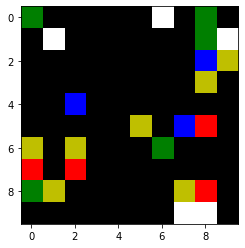

In [267]:
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

## Simulation

In [268]:
grids = []
grid = np.copy(original_grid)

for t in range(1, t_total+1):
    for ant in ants:
        
        if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
            p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y], grid))
            
            if random.random() <= p_pickup:
                ant.pickup(grid[ant.x, ant.y])
                grid[ant.x, ant.y] = 0
                
        elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object, grid))
            
            if random.random() <= p_drop:
                grid[ant.x, ant.y] = ant.object
                ant.drop()
        
        ant.move(ants)
        
    if t % 1000 == 0:
        grids.append(np.copy(grid))

for ant in ants:
    while ant.laden:
        if grid[ant.x, ant.y] == 0:
            grid[ant.x, ant.y] = ant.object
            ant.drop()
        else:
            ant.move(ants)

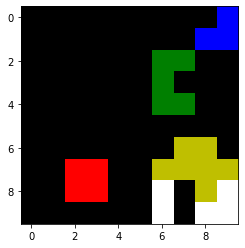

In [269]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

# Clustered ant sorting

In [270]:
class Cluster:
    """cluster object"""
    
    def __init__(self):
        self.x = []
        self.y = []
        self.positions = []
        self.objects = []
        self.object_type = 0

    def add_object(self, x, y, object):
        self.x.append(x)
        self.y.append(y)
        self.positions.append((x, y))
        self.objects.append(object)
        self.object_type = np.mean(self.objects)
        

In [271]:
def calculate_clusters(grid):
    """Converts object into clusters, adjacent objects are put into the same cluster"""
    # clusters for objects
    clusters = []
    cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    # clusters for zeros
    zero_clusters = []
    zero_cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    
    
    #iterate over all grid cells
    for x in range(grid_size):
        for y in range(grid_size):
            
            # if it's an object
            if grid[x, y] != 0:

                # if the object is not in a cluster
                if cluster_grid[x, y] == 0:

                    # make a cluster
                    clusters.append(Cluster())
                    clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
                    cluster_grid[x, y] = len(clusters)

                    # add neighboring positions to the cluster using greedy search
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in clusters[len(clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                same_type = [n for n in neighbors if grid[n[0], n[1]] == clusters[len(clusters) - 1].object_type]
                                for s in same_type:
                                    clusters[len(clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    cluster_grid[s[0], s[1]] = len(clusters)
                                    added += 1
                        if added == 0:
                            done = True

            # if it's not an object, make clusters of zeros (the free space), useful for dropping clusters later on
            else:
                # if it's is not in a cluster
                if zero_cluster_grid[x, y] == 0:

                    # make a cluster
                    zero_clusters.append(Cluster())
                    zero_clusters[len(zero_clusters) - 1].add_object(x, y, grid[x, y])
                    zero_cluster_grid[x, y] = len(zero_clusters)

                    # add neighboring positions to the cluster using greedy search
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in zero_clusters[len(zero_clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                same_type = [n for n in neighbors if grid[n[0], n[1]] == zero_clusters[len(zero_clusters) - 1].object_type]
                                for s in same_type:
                                    zero_clusters[len(zero_clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    zero_cluster_grid[s[0], s[1]] = len(zero_clusters)
                                    added += 1
                        if added == 0:
                            done = True

        
                          
    return clusters, cluster_grid, zero_clusters, zero_cluster_grid

In [272]:
clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(original_grid)

In [273]:
len(clusters)

22

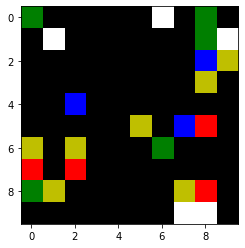

In [274]:
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

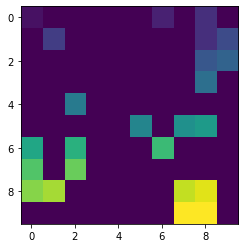

In [275]:
plt.imshow(cluster_grid);

In [276]:
len(zero_clusters)

2

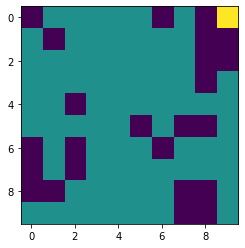

In [277]:
plt.imshow(zero_cluster_grid);

In [278]:
def Von_Neumann_drop(ant): 
    """Von Neumann drop method to drop clusters"""
    success = True
    
    #get location of ant
    x, y = ant.x, ant.y
    
    #virtual drop of first object in cluster
    temp_grid = np.copy(grid)
    temp_grid[x, y] = ant.object.objects[0]
    
    #iterative virtual drops of next objects in cluster
    for i in range(1, len(ant.object.objects)):
        
        #get location of all neighbours
        neighbours = von_neumann_neighbourhood(x, y)
        max_s = 0
        max_x = float("nan")
        max_y = float("nan")

        #iterate over neighbours
        for x_n, y_n in neighbours:
            #if cell is empty 
            if temp_grid[x_n, y_n] == 0:
                #calculate local density of next object in cluster
                s = local_density(x_n, y_n, ant.object.objects[i], temp_grid)
                #check if this neighbour is the current best neighbour
                if s > max_s:
                    max_s = s
                    max_x = x_n
                    max_y = y_n
        
        if np.isnan(max_x) != True:
            #virtual drop of object on best neighbour
            temp_grid[max_x, max_y] = ant.object.objects[i]
        
            #"move" to the best neighbour
            x = max_x
            y = max_y
            
        else:
            success = False
            break
            
    return success, temp_grid

## Parameters

In [296]:
grid_size = 7
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 1

In [297]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 12 objects and 2 ants on the grid.


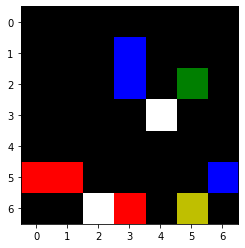

In [298]:
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

## Simulation

In [299]:
grids = []
grid = np.copy(original_grid)
clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)
ant_timer = 0
maxtime = grid_size**2

for t in range(1, t_total+1):
    
    # keep track of how many timesteps no clusters are dropped for surrounded cluster deadlock
    ant_timer += 1
    
    for ant in ants:
        
        # pickup
        if (ant.laden == False) and (grid[ant.x, ant.y] != 0):     
            
            # make sure ant doesn't pick up the last cluster of that type to avoid empty grid deadlock
            if sum([grid[ant.x, ant.y] == cluster.object_type for cluster in clusters]) > 1: 
                
                p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y], grid))            
                if random.random() <= p_pickup:
                    cluster = clusters[int(cluster_grid[ant.x, ant.y]) - 1]
                    ant.pickup(cluster)          
                    
                    # remove cluster & objects from the grid
                    for i in range(len(cluster.positions)):
                        grid[cluster.x[i], cluster.y[i]] = 0     
        
        # drop
        elif (ant.laden == True) and (grid[ant.x, ant.y] == 0):          
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object.object_type, grid))     
            if random.random() <= p_drop: 
                
                # find the zero cluster that the ant is currently in
                for zero_cluster in zero_clusters:
                     if (ant.x, ant.y) in zero_cluster.positions:
                        break
     
                # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                if len(ant.object.objects) <= len(zero_cluster.objects):
                    # Neumann drop the cluster             
                    success, temp_grid = Von_Neumann_drop(ant)
                    print(success)
                    if success:
                        grid = temp_grid
                        ant.drop()
                        ant_timer = 0
        
        # if no clusters have been dropped for too long, force ants to walk around until they drop their clusters
        # to avoid surrounded cluster deadlock (takes very long)
        if ant_timer == maxtime:     
            for ant in ants:
                if ant.laden:        
                    success = False
                    while not success:
                        ant.move(ants)
                        # make sure the grid is empty and the ant is adjacent to a cluster of the same type
                        if grid[ant.x, ant.y] == 0 and drop_probability(local_density(ant.x, ant.y, ant.object.object_type, grid)) > 0:                
                            # find the zero cluster that the ant is currently in
                            for zero_cluster in zero_clusters:
                                if (ant.x, ant.y) in zero_cluster.positions:
                                    break    
                            # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                            if len(ant.object.objects) <= len(zero_cluster.objects):
                                # Neumann drop the cluster             
                                success, temp_grid = Von_Neumann_drop(ant)
                                print(success)
                    grid = temp_grid
                    ant.drop()
                    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)
        
        ant.move(ants)
        # merge adjacent clusters of same type by recalculating
        clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)
    
    if t % 1000 == 0:
        grids.append(np.copy(grid))

print("Done")        
        
# force the ants to drop at the end of the simulation
for ant in ants:
    if ant.laden:        
        success = False
        while not success:
            ant.move(ants)
            # make sure the grid is empty and the ant is adjacent to a cluster of the same type
            if grid[ant.x, ant.y] == 0 and drop_probability(local_density(ant.x, ant.y, ant.object.object_type, grid)) > 0:                
                # find the zero cluster that the ant is currently in
                for zero_cluster in zero_clusters:
                    if (ant.x, ant.y) in zero_cluster.positions:
                        break    
                # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                if len(ant.object.objects) <= len(zero_cluster.objects):
                    # Neumann drop the cluster             
                    success, temp_grid = Von_Neumann_drop(ant)
                    print(success)
        grid = temp_grid
        ant.drop()
        clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)

True
True
True
Done


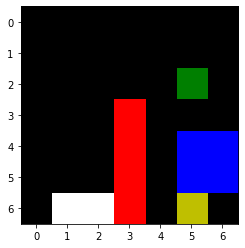

In [300]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

In [301]:
sum(sum(original_grid != 0))

10

In [302]:
sum(sum(grid != 0))

12

### Cluster distances

In [304]:
def cluster_distances(clusters):
    
    # cluster distance matrix, contains the minimum euclidean distance between 2 clusters
    D = np.zeros((len(clusters), len(clusters)))

    # all pairwise cluster combinations
    comb = combinations([i for i in range(len(clusters))], 2)

    # for each cluster combination
    for i, j in comb:
        A = clusters[i]
        B = clusters[j]
        d_min = grid_size
        # loop over every position in each of the clusters to find the closest objects
        for k in range(len(A.objects)):
            for l in range(len(B.objects)):
                a = A.positions[k]
                b = B.positions[l]
                # euclidean distance
                d = dist(a, b)
                if d < d_min:
                    d_min = d
        # symmetric
        D[i, j] = d_min
        D[j, i] = D[i, j]
        
    return D

In [306]:
D = cluster_distances(clusters)

In [347]:
def type_distances(clusters, D):
    
    # the clusters and their types
    cluster_types = [(i, int(clusters[i].object_type)) for i in range(len(clusters))]
    
    # all types
    types = set([int(cluster.object_type) for cluster in clusters])

    # type distance matrix, contains the average distance between the colors/cluster types
    T = np.zeros((len(types), len(types)))

    # all pairwise type combinations, including to the same type
    comb = combinations_with_replacement(types, 2)
    
    # for each type combination
    for i, j in comb:
        # find the clusters of those types
        A = [cluster[0] for cluster in cluster_types if cluster[1] == i]
        B = [cluster[0] for cluster in cluster_types if cluster[1] == j]
        d = 0
        n = 0
        # for all combinations of those different type clusters, retrieve the distance from distance matrix
        for a in A:
            for b in B:
                d += D[a, b]
                n += 1
        # divide total distance by amount of combinations => average distance
        T[i-1, j-1] = d/n
        T[j-1, i-1] = T[i-1, j-1]
        
        # average distance of the red cluster to all other colored clusters (non-red)
        av_d_r_o = np.mean(T[0, 1:])
        # average distance of the red cluster to same colored clusters (red)
        av_d_r_s = np.mean(T[0, 0])
        # average distance of all clusters to all other colored clusters
        av_d_a_o = (T.sum(axis=1) - T.diagonal()).sum()/(len(types)-1)**2
        # average distance of all clusters to all same colored clusters
        av_d_a_s = np.mean(np.diagonal(T))
        
    return T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s

In [348]:
T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s = type_distances(clusters, D)

In [349]:
av_d_a_o, av_d_a_s

(3.1747932047085214, 0.0)

## Continuous vector sorting

In [ ]:
# downloading iris dataset
from urllib.request import urlretrieve
import pandas as pd
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df = pd.read_csv(iris, sep=',')
attributes = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df.columns = attributes

In [ ]:
df.head()

In [ ]:
# convert class to a number
df['class_n'] = [i[0] for j in df['class'] for i in enumerate(set(df['class'])) if j == i[1]]

In [ ]:
df.head()

In [ ]:
# dissimilarity matrix between each sample vector
DIS = np.zeros((len(df), len(df)))

comb = combinations(df.index, 2)

vectors = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()

for i, j in comb:
    # euclidean distance as dissimilarity measure
    DIS[i, j] = dist(vectors[i],  vectors[j])
    DIS[j, i] = DIS[i, j]
    
# normalize matrix between 0 and 1
DIS = DIS/DIS.max()

In [ ]:
plt.hist(DIS.flatten());

In [ ]:
np.mean(DIS.flatten())

In [ ]:
def vector_dissimilarity(vector_o, vector_n):
    """calculate dissimilarity between vector objects"""
    dis = DIS[vector_o - 1, vector_n - 1]
    return dis

In [ ]:
def vector_local_density(x, y, object, grid):
    """calculate local density
        x, y = coordinates of the cell
        object = object the ant is holding"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - vector_dissimilarity(object, grid[x_n, y_n])/alpha
        
    return max(0, similarity/s2)

In [ ]:
def run_vector_simulation(original_grid, ants):

    grids = []
    grid = np.copy(original_grid)

    for t in range(1, t_total+1):
        for ant in ants:

            if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
                p_pickup = pickup_probability(vector_local_density(ant.x, ant.y, grid[ant.x, ant.y], grid))

                if random.random() <= p_pickup:
                    ant.pickup(grid[ant.x, ant.y])
                    grid[ant.x, ant.y] = 0

            elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
                p_drop = drop_probability(vector_local_density(ant.x, ant.y, ant.object, grid))

                if random.random() <= p_drop:
                    grid[ant.x, ant.y] = ant.object
                    ant.drop()

            ant.move(ants)

        if t % 1000 == 0:
            grids.append(np.copy(grid))

    for ant in ants:
        while ant.laden:
            if grid[ant.x, ant.y] == 0:
                grid[ant.x, ant.y] = ant.object
                ant.drop()
            else:
                ant.move(ants)

    return grid, grids

In [ ]:
grid_size = 10
ant_density = 0.05
object_density = 0.25
n_object_types = len(df)
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 0.7

In [ ]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

In [ ]:
# color the objects according to their flower class
original_class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if original_grid[x, y] != 0:
            original_class_grid[x, y] = int(df['class_n'].loc[[original_grid[x, y] - 1]]) + 1
            
plt.imshow(original_class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));

In [ ]:
grid, grids = run_simulation(original_grid, ants)

In [ ]:
# color the objects according to their flower class
class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if grid[x, y] != 0:
            class_grid[x, y] = int(df['class_n'].loc[[grid[x, y] - 1]]) + 1
            
plt.imshow(class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));